In [1]:
import pandas as pd
import nltk
import warnings
warnings.simplefilter('ignore')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


# read data
reviews_df = pd.read_csv("chrome_reviews.csv")
reviews_df = reviews_df[["Text", "Star"]]
reviews_df.head()

#df.loc[df[‘Star’] >=3]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,Text,Star
0,This is very helpfull aap.,5
1,Good,3
2,Not able to update. Neither able to uninstall.,1
3,Nice app,4
4,Many unwanted ads,1


In [2]:
reviews_df.isnull().sum()

Text    1
Star    0
dtype: int64

In [3]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

reviews_df['Text'] = reviews_df['Text'].astype(str)

def clean_text(a):
    # lower text
    a = a.lower()
    # tokenize text and remove puncutation
    a = [word.strip(string.punctuation) for word in a.split(" ")]
    # remove words that contain numbers
    a = [word for word in a if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    a = [x for x in a if x not in stop]
    # remove empty tokens
    a = [t for t in a if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(a)
    # lemmatize text
    a = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    a = [t for t in a if len(t) > 1]
    # join all
    a = " ".join(a)
    return(a)

# clean text data
reviews_df["review_clean"] = reviews_df["Text"].apply(lambda x: clean_text(x))
reviews_df.head()

,Text,Star,review_clean
0,This is very helpfull aap.,5,helpfull aap
1,Good,3,good
2,Not able to update. Neither able to uninstall.,1,able update neither able uninstall
3,Nice app,4,nice app
4,Many unwanted ads,1,many unwanted ad


To clean textual data, we call our custom 'clean_text' function that performs several transformations:
1.   lower the text
2.   tokenize the text (split the text into words) and remove the    punctuation
3.   remove useless words that contain numbers
4.   remove useless stop words like 'the', 'a' ,'this' etc.
5.   Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
6.   lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)







##**Feature Engineering**

In [4]:
# add sentiment anaylsis columns
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["Text"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into accout the context of the sentences to determine the sentiment scores. For each text, Vader retuns 4 values:
1.  a neutrality score
2.  a positivity score
3.  a negativity score
4.  an overall score that summarizes the previous scores

We will integrate those 4 values as features in our dataset.

In [5]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["Text"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["Text"].apply(lambda x: len(x.split(" ")))

Next, we add some simple metrics for every text:
1. number of characters in the text
2. number of words in the text

In [6]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

The next step consist in extracting vector representations for every review. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [7]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

Finally we add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document.

But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn't take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:

1. TF computes the classic number of times the word appears in the text
2. IDF computes the relative importance of this word which depends on how many texts the word can be found.

We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

In [8]:
reviews_df.head()

,Text,Star,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_aap,word_able,word_absolutely,word_access,word_account,word_ad,word_add,word_allow,word_alot,word_already,word_also,word_always,word_amaze,word_amazing,word_and,word_android,word_annoy,word_another,word_answer,word_anymore,word_anyone,word_anything,word_app,word_application,word_apps,word_around,...,word_ui,word_unable,word_understand,word_uninstall,word_uninstalled,word_update,word_updated,word_updating,word_use,word_useful,word_useless,word_user,word_ve,word_version,word_video,word_view,word_virus,word_want,word_watch,word_way,word_web,word_website,word_week,word_well,word_what,word_whenever,word_wish,word_without,word_wonderful,word_wont,word_work,word_working,word_world,word_would,word_wow,word_wrong,word_xxx,word_year,word_yes,word_yet
0,This is very helpfull aap.,5,helpfull aap,0.000,1.000,0.000,0.0000,26,5,-0.147574,0.039811,0.044163,-0.002567,-0.114536,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Good,3,good,0.000,0.000,1.000,0.4404,4,1,0.006717,0.026942,0.012612,0.002757,-0.037106,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Not able to update. Neither able to uninstall.,1,able update neither able uninstall,0.000,1.000,0.000,0.0000,46,8,0.008121,0.151209,0.057642,-0.094883,0.052316,0.0,0.815526,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.537434,0.0,0.214668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Nice app,4,nice app,0.000,0.263,0.737,0.4215,8,2,0.026074,0.007896,-0.078288,0.048715,-0.017163,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.646136,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Many unwanted ads,1,many unwanted ad,0.487,0.513,0.000,-0.2263,17,3,0.049547,-0.020999,-0.089492,-0.096736,-0.099300,0.0,0.000000,0.0,0.0,0.0,0.759923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
reviews_df.shape

(7204, 391)

# **Exploratory Data Analysis**

In [10]:
# show review distribution
reviews_df["Star"].value_counts(normalize = True)

5    0.537340
1    0.262909
4    0.090505
3    0.062604
2    0.046641
Name: Star, dtype: float64

53.7% ratings are 5 star ratings, 9.05% ratings are 4 star ratings, 6.2% ratings are 3 star ratings, 4.6% ratings are 2 star ratings and 26% ratings are 1 star ratings

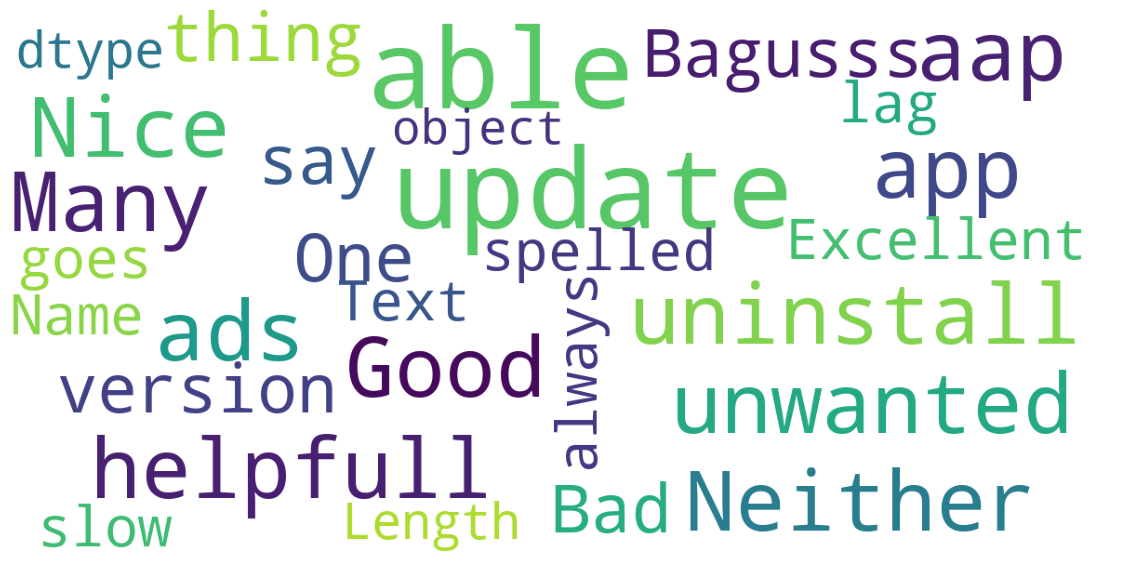

In [11]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["Text"])


In [12]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["Text", "pos"]].head(10)

,Text,pos
1751,Wonderful! I love Google! :),0.920
6953,Fabulous & osumm & fantastic & excellent & ama...,0.879
727,🆘 help 🌝 love it,0.873
4359,"Good 💯great, useful. Thanks 🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏",0.813
4694,"Clean, fast and easy Thanks",0.810
4472,So nice i love it,0.791
1054,Great app. I like it!,0.775
1219,oyeah. cool. best. fantastic. okeah. done,0.771
4222,Excellent App & Good service 👍,0.767
4212,Top 1 number 1 browser,0.756


In [13]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["Text", "neg"]].head(10)

,Text,neg
4337,Day by day get worst worst worst,0.755
1198,Horrible! Much worse than I thought?😓,0.697
4509,STUPID UPDATES WITH STUPID TAB 😠😠,0.674
3495,Horrible to navigate. I avoid using,0.655
6994,Bad effect slow net updated problem big problem,0.640
4510,Group tab app crash :/,0.630
1526,Google Chrome Update Problem. Worse App,0.592
1535,Google Chrome Update Problem. Worse app .,0.592
6244,Update not install please help,0.584
1520,The worst. Suddenly stopped working and consta...,0.580


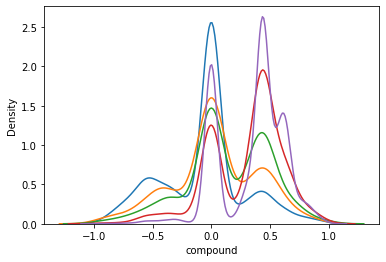

In [14]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [1,2,3,4,5]:
    subset = reviews_df[reviews_df['Star'] == x]
    
    # Draw the density plot
    if x==3 or x==4 or x==5:
        label ="Good reviews"
    else:
        label="Bad reviews"    
    sns.distplot(subset['compound'],hist=False, label = label)


##**Modelling Reviewer Score**

In [15]:
# feature selection
reviews_df["good_reviews"] = reviews_df["Star"].apply(lambda x: 1 if x >=3 else 0)
new_df=reviews_df.drop("Star",axis=1)
new_df.head()

,Text,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_aap,word_able,word_absolutely,word_access,word_account,word_ad,word_add,word_allow,word_alot,word_already,word_also,word_always,word_amaze,word_amazing,word_and,word_android,word_annoy,word_another,word_answer,word_anymore,word_anyone,word_anything,word_app,word_application,word_apps,word_around,word_asap,...,word_unable,word_understand,word_uninstall,word_uninstalled,word_update,word_updated,word_updating,word_use,word_useful,word_useless,word_user,word_ve,word_version,word_video,word_view,word_virus,word_want,word_watch,word_way,word_web,word_website,word_week,word_well,word_what,word_whenever,word_wish,word_without,word_wonderful,word_wont,word_work,word_working,word_world,word_would,word_wow,word_wrong,word_xxx,word_year,word_yes,word_yet,good_reviews
0,This is very helpfull aap.,helpfull aap,0.000,1.000,0.000,0.0000,26,5,-0.147574,0.039811,0.044163,-0.002567,-0.114536,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Good,good,0.000,0.000,1.000,0.4404,4,1,0.006717,0.026942,0.012612,0.002757,-0.037106,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Not able to update. Neither able to uninstall.,able update neither able uninstall,0.000,1.000,0.000,0.0000,46,8,0.008121,0.151209,0.057642,-0.094883,0.052316,0.0,0.815526,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.537434,0.0,0.214668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,Nice app,nice app,0.000,0.263,0.737,0.4215,8,2,0.026074,0.007896,-0.078288,0.048715,-0.017163,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.646136,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,Many unwanted ads,many unwanted ad,0.487,0.513,0.000,-0.2263,17,3,0.049547,-0.020999,-0.089492,-0.096736,-0.099300,0.0,0.000000,0.0,0.0,0.0,0.759923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [16]:
# feature selection
label = "good_reviews"
ignore_cols = [label, "Text", "review_clean"]
features = [c for c in new_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_df[features], new_df[label], test_size = 0.20, random_state = 42)

In [17]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores1=cross_val_score(rf,X_train,y_train,scoring="accuracy",cv=10)

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print('''Prediciting Test Set Result for Random Forest Classification''')
print('''Making Confusion Matrix''')
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm,'\n')
print('True Positives :',cm[0][0])
print('False Positives :',cm[0][1])
print('False Negatives :',cm[1][0])
print('True Negatives :', cm[0][1],'\n')

print('''Classification Report''')
print(classification_report(y_test, y_pred,target_names=['positive', 'negative'], zero_division=1))

print('''Evaluating Random FOrest Classification Model Performance''')
accuracy = accuracy_score(y_test, y_pred)
print(accuracy,'\n')

print('''Applying Cross validation''')
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(rf, X_train, y_train, cv=10)
print("Accuracy for Random Forest Classification: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation for Random Forest Classification: {:.2f} %".format(accuracies.std()*100),'\n')


Prediciting Test Set Result for Random Forest Classification
Making Confusion Matrix
[[340 119]
 [113 869]] 

True Positives : 340
False Positives : 119
False Negatives : 113
True Negatives : 119 

Classification Report
              precision    recall  f1-score   support

    positive       0.75      0.74      0.75       459
    negative       0.88      0.88      0.88       982

    accuracy                           0.84      1441
   macro avg       0.82      0.81      0.81      1441
weighted avg       0.84      0.84      0.84      1441

Evaluating Random FOrest Classification Model Performance
0.8390006939625261 

Applying Cross validation
Accuracy for Random Forest Classification: 84.49 %
Standard Deviation for Random Forest Classification: 1.36 % 



In [45]:
train_df = pd.DataFrame({"model predictions": y_pred, "labels": y_test})
result_df=new_df[new_df['good_reviews']==1]
final_df=result_df.loc[:,['Text','good_reviews']]
pd.concat([final_df,train_df],axis=1,join='inner')


,Text,good_reviews,model predictions,labels
14,everything ia possible on chrome i like it,1,1,1
17,Low download speed,1,0,1
23,mydeviceshavebeenhacked and im just a humble c...,1,0,1
41,Thanks Cool,1,1,1
45,Kamrulhasan,1,1,1
...,...,...,...,...
7167,❤️,1,1,1
7174,Best,1,1,1
7184,Good,1,1,1
7186,من یه سایت دارم که فیلم می بینید بهتون دلار می...,1,1,1
